In [10]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

#Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

%matplotlib inline

In [11]:
train_audio_path = 'dataSets/hello/'
filename_Before =  'Before.wav'
filename_After = 'After.wav'
sample_rate_B, samples_B = wavfile.read(str(train_audio_path) + filename_Before)
sample_rate_A, samples_A = wavfile.read(str(train_audio_path) + filename_After)

In [12]:
#로그 스펙트로그램을 계산하는 함수
def log_specgram(audio, sample_rate, window_size=20, step_size = 10,
                eps = 1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    #연속 푸리에 변환을 해 스펙트로그램을 계산하는 함수
    freqs, times, spec = signal.spectrogram(audio,
                                           fs = sample_rate,
                                           window='hann',
                                            #여기 윈도우 매개변수에 들어간 부분이
                                            #window function들 중에 하나이다.
                                            #시가눅에서 Window Function을 곱하는 것은, 주파수 축에서 Filtering이라고 한단다. 
                                            #Window의 주파수 스펙트럼을, 원래 입력 신호의 주파수 스펙트럼과 convolution해서 조금 더 부드럽고
                                            #side lobe가 사라진 주파수 스펙트럼을 만들 수 있다. But 단점으로는 Main lobe가 두꺼워진다는 점.
                                            #Cosine, Raised Cosine, Hamming, Hanning, Blackman, Triangular, Gaussian 등이 있다.
                                           nperseg = nperseg,
                                            
                                           noverlap=noverlap,
                                            #각 윈도우들을 겹치게 할지를 결정하는 매개변수
                                           detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [19]:
#나이퀴스트 이론에 따라 주파수가 8000Hz니까 샘플링 레이트는 2배인 16000으로 잡아준다.
print("Before Sample_rate : " + str(sample_rate_B))
print("After Sample_rate : " + str(sample_rate_A))


Before Sample_rate : 16000
After Sample_rate : 16000


In [20]:
#Sample에는 
#data : numpy array
#Data read from wav file.  Data-type is determined from the file;
#see Notes.
#라고 나와있는데 웨이브 파일에 대한 데이터라고 한다. 타입은 PCM 별로 값의 범위가 달라짐.
#정확하겐 모르겠으니 이론책을 참고한 후 다시 확인해봐야겠다.
print("Before Samples : " + str(samples_B))
print("After Samples: " + str(samples_A))

Before Samples : [ 3 -1 -4 ...  0  0  0]
After Samples: [ 0  0  0 ... 34 35 33]


In [6]:
#Sample의 demension을 확인해보니 16000개가 나온다. Sample_rate만큼 wav파일을
#자르는거같은데 정확하게는 잘모르겠다. Sampling_rate만큼인지, 단위가 따로 있는지
#더 알아봐야 할듯.
c =np.shape(samples)
c

(16000,)

Text(0.5,0,'Seconds')

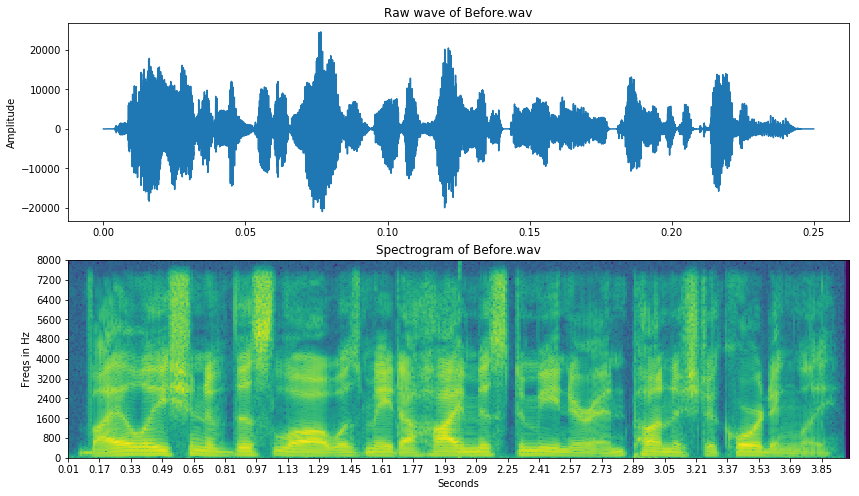

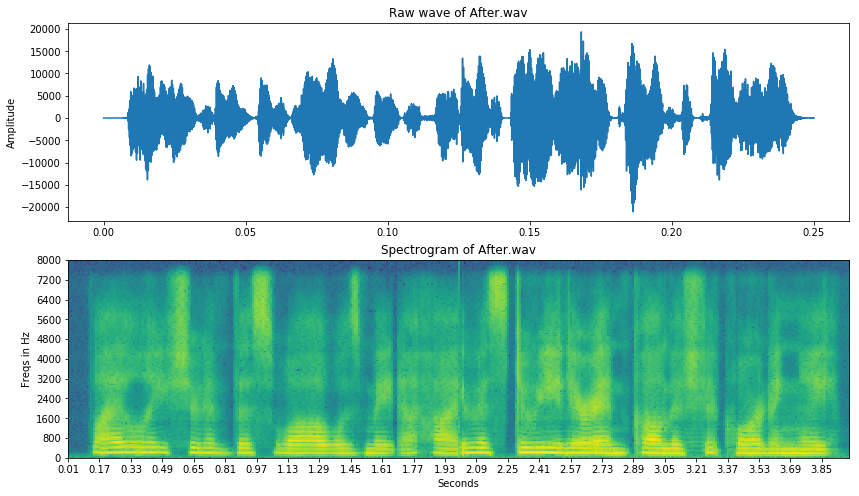

In [31]:
#주파수, 시간, 스펙트로그램을 Sample들과, Sample_Rate에 대해 값들을 계산한다.
freqs_B, times_B, spectrogram_B = log_specgram(samples_B, sample_rate_B)
freqs_A, times_A, spectrogram_A = log_specgram(samples_A, sample_rate_A)

fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename_Before)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate_B/len(samples_B), 4*sample_rate_B), samples_B)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram_B.T, aspect='auto', origin='lower',
          extent=[times_B.min(), times_B.max(), freqs_B.min(), freqs_B.max()])
ax2.set_yticks(freqs_B[::16])
ax2.set_xticks(times_B[::16])
ax2.set_title('Spectrogram of ' + filename_Before)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

fig2 = plt.figure(figsize=(14,8))
ax3 = fig2.add_subplot(211)
ax3.set_title('Raw wave of ' + filename_After)
ax3.set_ylabel('Amplitude')
ax3.plot(np.linspace(0, sample_rate_A/len(samples_A), 4*sample_rate_A), samples_A)

ax4 = fig2.add_subplot(212)
ax4.imshow(spectrogram_A.T, aspect='auto', origin='lower',
          extent=[times_A.min(), times_A.max(), freqs_A.min(), freqs_A.max()])
ax4.set_yticks(freqs_A[::16])
ax4.set_xticks(times_A[::16])
ax4.set_title('Spectrogram of ' + filename_After)
ax4.set_ylabel('Freqs in Hz')
ax4.set_xlabel('Seconds')
